In [1]:
import os;import sys
import pandas as pd;import numpy as np;from itertools import combinations, permutations
from datetime import datetime;from datetime import date
from collections import Counter;import matplotlib ; from matplotlib import pyplot as plt
import networkx as nx; from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from scipy.io import loadmat
from scipy.sparse import csr_matrix
from scipy import stats
from sknetwork.clustering import Louvain, BiLouvain, modularity, bimodularity
import nbimporter ; import importlib as imp ; from scipy.optimize import minimize 
from scipy.optimize import LinearConstraint
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from random import gauss, random
import pickle; import math
import geopandas as gpd
import re

In [2]:
path=os.getcwd()

<h2 style='text-align: center;'> Bond & Loan Data </h2>

In [3]:
data = pd.read_csv('./../indicators/model_data_bonds_loans_df.csv')

In [4]:
data.head(3)

,Quarter,Year,Country,Delta_Interest_EU,Delta_Interest_JPY,Delta_Interest_US,ECB,Exchange_rate,FFR,FX_long,...,market_volume_loans,Amount,LCY,Currency,Domestic,Corporate,Industry,Bond,Tenor,Tenor_bracket
0,4,2020,Malaysia,3.8046,3.7546,3.9646,0.25,4.1478,0.09,0.016301,...,1.2578,0.0247,1,MYR,1,1,Consumer staples,0,9.404125,5-10 yrs
1,2,2010,Thailand,-0.5000,0.9500,1.0500,1.75,32.4913,0.20,0.018714,...,0.0000,0.0587,1,THB,1,1,Energy,0,18.000000,>10 yrs
2,3,2022,Mexico,7.7200,8.9200,7.5400,1.50,20.0101,1.68,0.033409,...,12.2003,0.1365,1,MXN,1,1,Industrials,1,4.000000,0-5 yrs


In [5]:
data.Country.unique()

array(['Malaysia', 'Thailand', 'Mexico', 'India', 'Brazil',
       'South Africa', 'Turkey', 'Indonesia'], dtype=object)

In [6]:
indicator_df = pd.read_csv('./../indicators/indicator_df.csv')
indicator_df = indicator_df.rename(columns={'Unnamed: 0': 'Country','Unnamed: 1':'Indicator'})
indicator_df = indicator_df.set_index(['Country','Indicator'])

<h1><center>Debt valuation</center></h1>



In [7]:
years = range(2004,2025)

In [8]:
countries = ['Malaysia','India','Brazil','Mexico','South Africa',
             'Thailand','Indonesia','Turkey']

In [9]:
quarters = ['Q{}-{}'.format(Q,Y) for Y in years \
            for Q in range(1,5)][:-2]

In [10]:
# value of dollar/EUR/yen debt as of date of issue
D_dollar_debt_df = pd.DataFrame(0, 
                              columns = quarters,
                              index = sorted(countries))
dollar_debt_df = pd.DataFrame(0, 
                              columns = quarters,
                              index = sorted(countries))

for c in countries:
    data_c = data[data.Country == c]
    for i, row in data_c.iterrows():
        if row.Currency == 'USD':
            q_maturity = int(row.Tenor)*4
            Q0 = 'Q{}-{}'.format(row.Quarter, row.Year)
            if Q0 in quarters:
                Q0_index = quarters.index(Q0)
                for q in range(Q0_index, Q0_index + q_maturity):
                        ER0 = indicator_df.loc[c,
                              'Exchange_rate'][quarters[Q0_index]]
                        ERq = indicator_df.loc[c,
                              'Exchange_rate'][quarters[q]]
                        D_dollar_debt_df.loc[c,quarters[q]] += row.Amount*(ERq-ER0)/ER0
                        dollar_debt_df.loc[c,quarters[q]] += row.Amount
                        if q+1==len(quarters): break
        
        if row.Currency == 'EUR':
            q_maturity = int(row.Tenor)*4
            Q0 = 'Q{}-{}'.format(row.Quarter, row.Year)
            if Q0 in quarters:
                Q0_index = quarters.index(Q0)
                for q in range(Q0_index, Q0_index + q_maturity):
                        ER0 = indicator_df.loc[c,
                              'Exchange_rate'][quarters[Q0_index]]/\
                                indicator_df.loc[c,
                              'Exchange_rate_EUR'][quarters[Q0_index]]
                        
                        ERq = indicator_df.loc[c,
                              'Exchange_rate'][quarters[q]]/\
                        indicator_df.loc[c,
                              'Exchange_rate_EUR'][quarters[q]]
                        D_dollar_debt_df.loc[c,quarters[q]] += row.Amount*(ERq-ER0)/ER0
                        dollar_debt_df.loc[c,quarters[q]] += row.Amount
                        if q+1==len(quarters): break
        if row.Currency == 'JPY':
            q_maturity = int(row.Tenor)*4
            Q0 = 'Q{}-{}'.format(row.Quarter, row.Year)
            if Q0 in quarters:
                Q0_index = quarters.index(Q0)
                for q in range(Q0_index, Q0_index + q_maturity):
                        ER0 = indicator_df.loc[c,
                              'Exchange_rate'][quarters[Q0_index]]/\
                                indicator_df.loc[c,
                              'Exchange_rate_JPY'][quarters[Q0_index]]
                        
                        ERq = indicator_df.loc[c,
                              'Exchange_rate'][quarters[q]]/\
                        indicator_df.loc[c,
                              'Exchange_rate_JPY'][quarters[q]]
                        D_dollar_debt_df.loc[c,quarters[q]] += row.Amount*(ERq-ER0)/ER0
                        dollar_debt_df.loc[c,quarters[q]] += row.Amount
                        if q+1==len(quarters): break

### Quarterly valuation effects by country 

In [22]:
countries = ['India', 'Brazil', 'Turkey', 'Mexico',
       'South Africa','Indonesia']

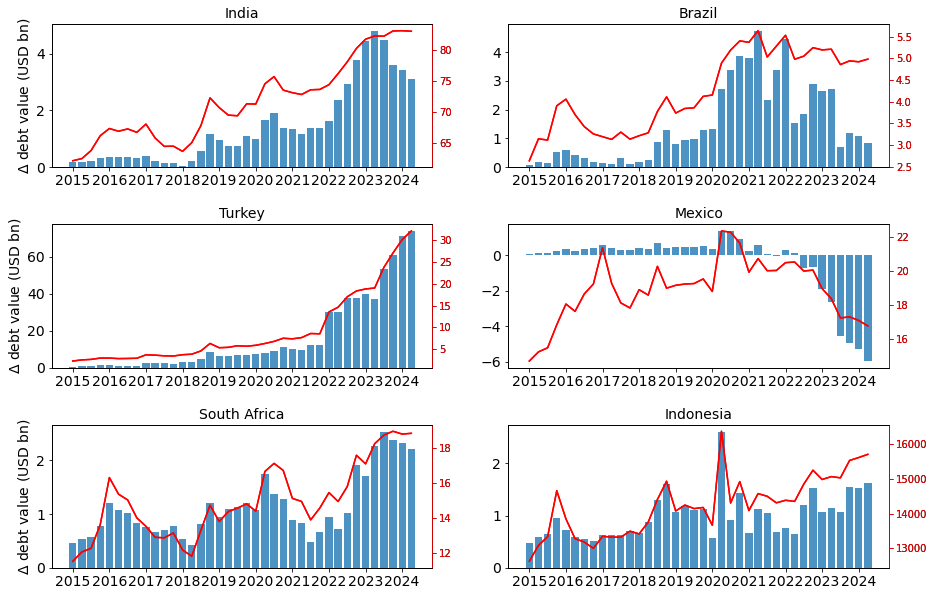

In [23]:
nrow, ncol = 3,2
fig, ax = plt.subplots(nrow, ncol, figsize=(15,10))
fs, a = 14, 0.8
years = range(2015,2025)
quarters = ['Q{}-{}'.format(Q,Y) for Y in years \
            for Q in range(1,5)][:-2]

for i,c in enumerate(countries):
    row, col = int(np.floor(i/ncol)), int(i%ncol)
    ax[row, col].tick_params(axis='both', labelsize=fs)
    ax[row, col].bar(quarters, 
                     D_dollar_debt_df.loc[c][quarters],
                    alpha = a)
    ax2=ax[row,col].twinx()
    ax2.plot(quarters,
             indicator_df.loc[c,'Exchange_rate'][quarters].values,
            color='red')
    if col == 0:
        ax[row, col].set_ylabel('$\Delta$ debt value (USD bn)', 
                                fontsize=fs);
    ax[row, col].set_title(c,fontsize=fs);
    ax[row, col].set_xticks([quarters[i] for i in range(0,len(quarters),4)]);
    ax[row, col].set_xticklabels([quarters[i].split('-')[1] for i in range(0,len(quarters),4)],
                       fontsize=fs)
    
    # Exchange rate
    ax2=ax[row,col].twinx()
    ax2.plot(quarters,
             indicator_df.loc[c,'Exchange_rate'][quarters].values,
            color='red')
    ax2.spines['right'].set_color('red')
    ax2.tick_params(axis='y', colors='red')
    
fig.subplots_adjust(hspace=0.4)

### Quarterly valuation effects by major EMDEs

In [24]:
countries = ['Malaysia','India','Brazil','Mexico','South Africa',
             'Thailand','Indonesia','Turkey']

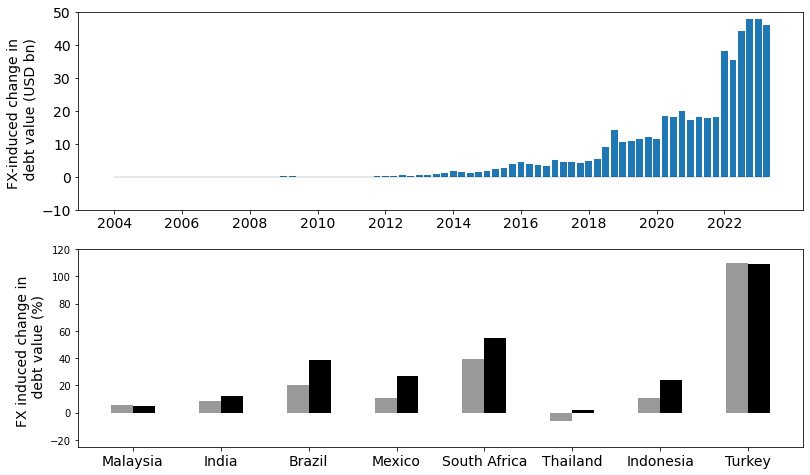

In [25]:
fig, ax = plt.subplots(2,1, figsize=(13,8))
fs=14
a=0.8
years = range(2004,2024)

quarters = ['Q{}-{}'.format(Q,Y) for Y in years \
            for Q in range(1,5)][:-2]
ax[0].plot(quarters,[0]*len(quarters),
           linewidth=0.2,
          color='black')
ax[0].bar(quarters, D_dollar_debt_df.loc[[c for 
                    c in countries]][quarters].sum(axis=0))
ax[0].set_ylabel('FX-induced change in \n debt value (USD bn)', fontsize=fs);
ax[0].set_xticks([quarters[i] for i in range(0,len(quarters),8)]);
ax[0].set_xticklabels([quarters[i].split('-')[1] 
                       for i in range(0,len(quarters),8)],
                   fontsize=fs);
ax[0].set_ylim(-10,50)

ax[0].tick_params(axis='both', labelsize=fs)
x=np.array(range(len(countries)))
ax[1].bar(x-0.125,
          [100*D_dollar_debt_df.loc[c]['Q4-2019']/\
           dollar_debt_df.loc[c]['Q4-2019']
          for c in countries],
         width=0.25,
          color='gray',
         alpha=a,
         )
ax[1].bar(x+0.125,
          [100*D_dollar_debt_df.loc[c]['Q2-2020']/\
           dollar_debt_df.loc[c]['Q2-2020']
          for c in countries],
          color='black',
          width=0.25)
ax[1].set_xticks(x)
ax[1].set_ylim(-25,120)
ax[1].set_xticklabels(countries, fontsize=fs);
ax[1].set_ylabel('FX induced change in \n debt value (%)', 
                 fontsize=fs);
fig.savefig('./../figs/fig_3.png',dpi=300)